# NeRF - From Scratch

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
import os

## 1. Load Dataset

In [2]:
if not os.path.exists('tiny_nerf_data.npz'):
    ! wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

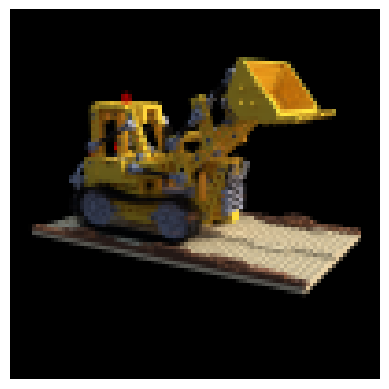

In [3]:
# Load data
dataset = np.load('tiny_nerf_data.npz')
images = dataset['images']
poses = dataset['poses']
focal_length = dataset['focal']
h, w = images.shape[1:3]

# Designate last image as test image
test_img, test_pose = images[-1], poses[-1]
images = images[:-1]
poses = poses[:-1]

plt.imshow(images[10])
plt.axis('off')
plt.show()

In [4]:
print(f'{images.shape=}, {poses.shape=}, {focal_length=}')

images.shape=(105, 100, 100, 3), poses.shape=(105, 4, 4), focal_length=array(138.8888789)


## 2. March Camera Rays Through Scene
**Input**: A set of camera poses $\{x_c, y_c, z_c, \gamma_c, \theta_c\}_n$

**Output**: A bundle of rays for every pose $\{v_o, v_d\}_{H \times W \times n}$

In [5]:
def get_rays_for_one_image(h, w, focal_length, T_cam_to_world):
    """Get ray origins and directions for each pixel in an image

    Args:
        h (int): Height of the image in pixels
        w (int): Width of the image in pixels
        focal_length (float): Focal length of the camera
        T_cam_to_world (ndarray): 4x4 Transform from camera to world coordinates 
    """
    
    # Create a grid of pixel coordinates (i, j) for the width and height of the image.
    x, y = torch.meshgrid(torch.arange(w, dtype=torch.float32), torch.arange(h, dtype=torch.float32))
    # Shift the pixel grid so that center of the image is at (0,0)
    x = x - w * 0.5
    y = y - h * 0.5
    
    # Calculate the directions of the rays from the camera center through each pixel
    dirs = torch.stack([x / focal_length, -y / focal_length, torch.full_like(x, -1)], dim=-1)

    # Transform the ray directions from camera coords to world coords using the rotation part of T_cam_to_world
    # torch.unsqueeze(dirs, -2) adds a dim: [h,w,3] -> [h,w,1,3]
    v_d = torch.sum(torch.unsqueeze(dirs, -2) * T_cam_to_world[:3, :3], -1) 

    # Camera position in world coords = ray origins
    # Broadcasted to match shape of rays_d, so every ray originates from the camera position.
    v_o = T_cam_to_world[:3, -1].expand_as(v_d)

    return v_o, v_d

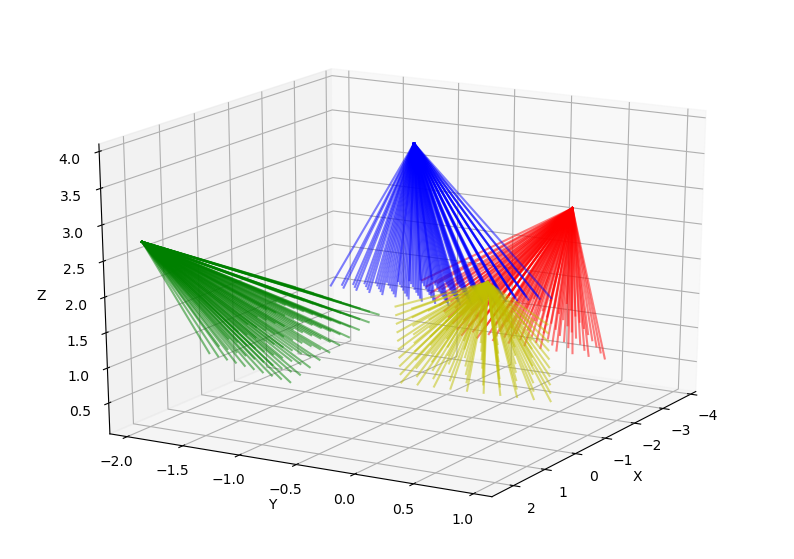

In [6]:
# Test march_rays_for_one_image by passing some poses

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
colors = ['r-', 'g-', 'b-', 'y-', 'c-']

for idx, pose in enumerate(poses[5:9]):
    T_cam_to_world = torch.tensor(pose, dtype=torch.float32)
    v_o, v_d = get_rays_for_one_image(h, w, focal_length, T_cam_to_world)
    # Plot a subset of rays to keep the plot understandable
    step = max(h // 10, 1)

    for i in range(0, h, step):
        for j in range(0, w, step):
            o = v_o[i, j, :].numpy()  # Converting to numpy array for matplotlib
            d = v_d[i, j, :].numpy() * 2

            # Plotting the ray from origin 'o' in direction 'd'
            ax.plot([o[0], o[0] + d[0]], [o[1], o[1] + d[1]], [o[2], o[2] + d[2]], colors[idx % len(colors)], alpha=0.5)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Setting the viewpoint for better visualization
ax.view_init(elev=20, azim=30)

plt.show()

## 3. Collect Query Points 
**Input**: A bundle of rays for every pose $\{v_o, v_d\}_{H \times W \times n}$

**Output**: A set of 3D query points $\{x_p, y_p, z_p\}_{n \times m \times H \times W}$

In [7]:
def get_query_points_for_one_image(v_o, v_d, m_samples=64, near=1, far=4):
    """
    Sample m points uniformly along a ray (for now)
    TODO: Implement hierarchical sampling
    
    Args:
        v_o (Tensor): Ray origins of shape (H, W, 3)
        v_d (Tensor): Ray directions of shape (H, W, 3)
        m_samples (int): Number of samples to take along each ray
        near (float): Near plane distance
        far (float): Far plane distance
        
    Returns:
        pts (Tensor): Points sampled along each ray of shape (H, W, m_samples, 3)
    """

    z_vals = torch.linspace(near, far, m_samples) 

    # Unsqueezing 'rays_o' and 'rays_d' to add a dimension for m_samples, and z_vals for the last dimension
    pts = v_o.unsqueeze(-2) + v_d.unsqueeze(-2) * z_vals.unsqueeze(-1)
    return pts

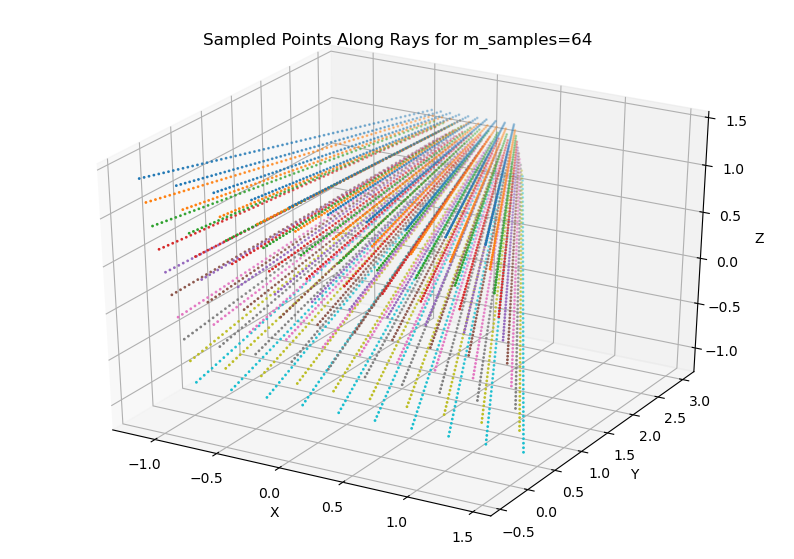

In [8]:
m_samples=64
T_cam_to_world = torch.tensor(poses[0], dtype=torch.float32)

# Generate ray origins and directions using the provided function
v_o, v_d = get_rays_for_one_image(h, w, focal_length, T_cam_to_world)
# Use the function to collect query points along the rays
pts = get_query_points_for_one_image(v_o, v_d, m_samples=m_samples, near=1, far=4)

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot a subset of rays and points for clarity
for i in range(0, h, 10):  # Skip some rays for clarity
    for j in range(0, w, 10):
        ray_pts = pts[i, j].cpu().numpy()  # Convert the points to numpy array for plotting
        ax.scatter(ray_pts[:, 0], ray_pts[:, 1], ray_pts[:, 2], s=1)  # Plot the points along the ray

# Setting labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title(f'Sampled Points Along Rays for m_samples={m_samples}')
plt.show()


## 4. Positional Encoding
**Input**: A set of 3D query points $\{x_p, y_p, z_p\}_{n \times m \times H \times W}$

**Output**: A set of query points embedded into $d$-dimensional space $\{x_1, x_2, ..., x_d\}_{n \times m \times H \times W}$

In [9]:
def positional_encoding(x, L):
    # x is of shape [H, W, m_samples, 3]
    # x = x.view(1, -1)
    out = [x]
    for i in range(L):
        out.append(torch.sin(2**i * np.pi * x))
        out.append(torch.cos(2**i * np.pi * x))
    return torch.cat(out, dim=-1) # [H, W, m_samples, 3 * 2 * L + 3]

IndexError: too many indices for tensor of dimension 1

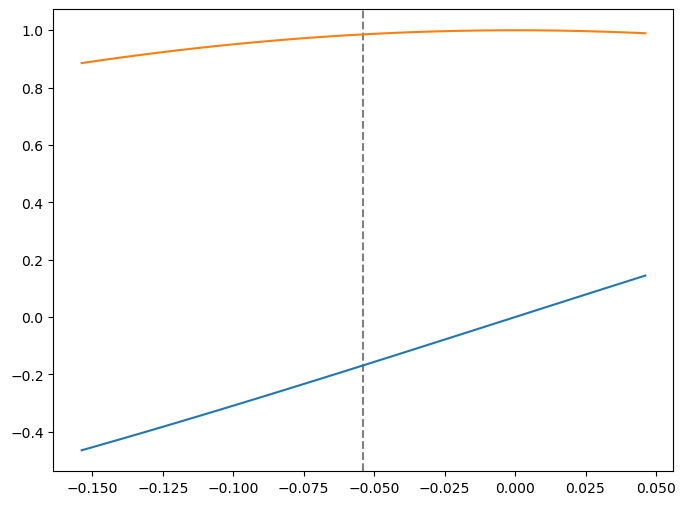

In [10]:
# Test positional_encoding
L=4
position = torch.tensor(poses[0][:3, 3], dtype=torch.float32)[0] # encoding for x pos
position = position.unsqueeze(0) if position.dim() == 0 else position
# apply positional encoding
encoded = positional_encoding(position, L)

# plot vals
x_vals = torch.linspace(position.item() - 0.1, position.item() + 0.1, 100).unsqueeze(-1)

plt.figure(figsize=(8, 6))

# draw line at position
plt.axvline(position.item(), color='gray', linestyle='--')

for i in range(L):
    sin_vals = torch.sin(2**i * np.pi * x_vals)
    cos_vals = torch.cos(2**i * np.pi * x_vals)
    
    # Plot sinusoid
    plt.plot(x_vals.squeeze().numpy(), sin_vals.squeeze().numpy(), label=f'Sin component {i}')
    plt.plot(x_vals.squeeze().numpy(), cos_vals.squeeze().numpy(), label=f'Cos component {i}')
    
    # Plot encoded point
    plt.scatter([position.item()], [encoded[0, 2*i+1].item()], color='blue')  # sin
    plt.scatter([position.item()], [encoded[0, 2*i+2].item()], color='green')    # cos
    

plt.title(f'Positional Encoding for L={L}, x={round(position.item(),4)}')
plt.xlabel('Input coord')
plt.ylabel('Encoded value')
plt.legend()
plt.grid(True)
plt.show()

## 5. Neural Network Inference
**Input**: A set of query points after positional encoding $\{x_1, x_2, ..., x_d\}_{n \times m \times H \times W}$

**Output**: RGB colour and volume density for every query point $\{RGB, \sigma\}_{n \times m \times H \times W}$ 

In [ ]:
class NeRFNetwork(nn.Module):
    def __init__(self, embed_pos=10, embed_dir=4, layer_size=256):
        super(NeRFNetwork, self).__init__()

        self.block1 = nn.Sequential(nn.Linear(embed_pos * 6 + 3, layer_size), nn.ReLU(),
                                    nn.Linear(layer_size, layer_size), nn.ReLU(),
                                    nn.Linear(layer_size, layer_size), nn.ReLU(),
                                    nn.Linear(layer_size, layer_size), nn.ReLU())

        self.block2 = nn.Sequential(nn.Linear(embed_dir * 6 + 3 + layer_size, layer_size), nn.ReLU(), # include output of first block, hence extra layer_size
                                    nn.Linear(layer_size, layer_size), nn.ReLU(),
                                    nn.Linear(layer_size, layer_size), nn.ReLU(),
                                    nn.Linear(layer_size, layer_size + 1))

        self.block3 = nn.Sequential(nn.Linear(layer_size * 6 + 3 + layer_size, layer_size // 2), nn.ReLU())
        self.block4 = nn.Sequential(nn.Linear(layer_size // 2, 3), nn.Sigmoid())

        self.embed_pos = embed_pos
        self.embed_dir = embed_dir

    def forward(self, o, d):
        emb_x = positional_encoding(o, self.embed_pos)
        emb_d = positional_encoding(d, self.embed_dir)
        h = self.block1(emb_x)
        tmp = self.block2(torch.cat((h, emb_x),dim=1))
        h, sigma = tmp[:, :-1], nn.ReLU(tmp[:,-1])
        c = self.block4(h)
        return c, sigma

In [ ]:
def query_nerf_network_for_one_ray(nerf, o, d):
    """
    Query the NeRF network for a single ray

    Args:
        nerf (NeRFNetwork): NeRF network
        o (Tensor): Ray origins of shape (3,)
        d (Tensor): Ray directions of shape (3,)

    Returns:
        c (Tensor): RGB color of the ray
        sigma (Tensor): Density of the ray
    """
    o = o.unsqueeze(0).unsqueeze(0)  # Add batch and m_samples dimensions
    d = d.unsqueeze(0).unsqueeze(0)  # Add batch and m_samples dimensions
    c, sigma = nerf(o, d)
    return c.squeeze(0), sigma.squeeze(0)

## 6. Volume Rendering

**Input**: A set of 3D query points (after positional encoding) + their volume profile + RGB value $\{x_1​,x_2​,...,x_d​,RGB,σ\}_{n\times m \times H \times W}​$ 

**Output**: A set of rendered images (one per pose) $\{H,W\}_n$

In [ ]:
def render_volume(query_points, rgb, sigma):
    # use rendering equation to calculate final color
    # each query point along the ray has a color and density
    pass

## 7. Training Loop

In [ ]:
def train(nerf, optimizer, points_n, dirs_n, images, num_epochs=1, batch_size=8):
    for epoch in range(num_epochs):
        # batch size determines how many rays to process in parallel
        for i in range(0, h*w, batch_size):
            # sample batch_size rays
            points = points_n[i:i+batch_size]
            dirs = dirs_n[i:i+batch_size]
            img = images[i:i+batch_size]
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # for each ray, query the NeRF network
            c, sigma = query_nerf_network_for_one_ray(nerf, points, dirs)
            
            # using the predicted color and sigma, render the volume and compare with the ground truth image
            rendered_img = render_volume(points, c, sigma)
            
            # calculate loss
            loss = torch.mean((img - rendered_img)**2)
            loss.backward()
            optimizer.step()
            
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')
        

## 8. Run!

In [ ]:
# TEMPORARY
images = images[:20]
poses = poses[:20]

In [13]:
m_samples = 64

points_list = []
dirs_list = []

for i in range(len(images)):
    T_cam_to_world = torch.tensor(poses[i], dtype=torch.float32) # [4,4]
    v_o, v_d = get_rays_for_one_image(h, w, focal_length, T_cam_to_world) # [H,W,3], [H,W,3]
    points = get_query_points_for_one_image(v_o, v_d, m_samples=m_samples, near=1, far=4) # [H,W,m_samples,3]
    
    # encoded_points = positional_encoding(points, L=4) 
    
    points_list.append(points)
    dirs_list.append(v_d)
    
    
points_n = torch.stack(points_list, dim=0) # [N,H,W,m_samples,3]
dirs_n = torch.stack(dirs_list, dim=0) # [N,H,W,3]
print(f'{points_n.shape=}, {dirs_n.shape=}') # points_n.shape=torch.Size([105, 100, 100, 64, 3]), dirs_n.shape=torch.Size([105, 100, 100, 3])

# points_n is all the query points (m sample points) for HxW rays for N images
# dirs_n is all the ray directions for HxW rays for N images

points_n.shape=torch.Size([105, 100, 100, 64, 3]), dirs_n.shape=torch.Size([105, 100, 100, 3])


In [ ]:
# Now have encoded points along each ray
# Pass through NeRF network to get color and sigma

nerf = NeRFNetwork(embed_pos=10, embed_dir=4, layer_size=256)
optimizer = torch.optim.Adam(nerf.parameters(), lr=1e-3)


In [ ]:
train(nerf, optimizer, points_n, dirs_n, images)